# 내가 낸 손은 가위일까, 바위일까, 보일까?
## 부제 : 일단 딥러닝 네트워크를 만들어 봅시다.
이번 시간에는 가위 바위 보 이미지를 학습시키는 네트워크를 짜보았다. 

In [4]:
!pip install pillow   

from PIL import Image
import os
import glob
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
print("이미지 디렉토리 경로: ", image_dir_path)

images=glob.glob(image_dir_path + "/*.jpg")  

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")

print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
print("이미지 디렉토리 경로: ", image_dir_path)

images=glob.glob(image_dir_path + "/*.jpg")  
# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")
print("바위 이미지 resize 완료!")


image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
print("이미지 디렉토리 경로: ", image_dir_path)
images=glob.glob(image_dir_path + "/*.jpg")  
# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
target_size=(28,28)
for img in images:
    old_img=Image.open(img)
    new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img.save(img,"JPEG")
print("보 이미지 resize 완료!")

이미지 디렉토리 경로:  /home/aiffel/aiffel/rock_scissor_paper/scissor
가위 이미지 resize 완료!
이미지 디렉토리 경로:  /home/aiffel/aiffel/rock_scissor_paper/rock
바위 이미지 resize 완료!
이미지 디렉토리 경로:  /home/aiffel/aiffel/rock_scissor_paper/paper
보 이미지 resize 완료!


In [7]:
import os
def load_data(img_path,img_num):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=img_num   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.

    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    #이미지를 차례대로 읽어들이면 오버피팅이 심할것 같아서 이미지를 일단 한 폴더채로 읽고, 그 안에서 이미지를 셔플했다. 
    idx=0
    tmp_idx=idx
    tmp_imgs=np.zeros(int(number_of_data/3)*img_size*img_size*color,dtype=np.int32).reshape(int(number_of_data/3),img_size,img_size,color)
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        tmp_imgs[tmp_idx,:,:,:]=img
        labels[tmp_idx]=0
        tmp_idx+=1
        
    np.random.shuffle(tmp_imgs)
    
    for ti in tmp_imgs:
        imgs[idx,:,:,:]=ti
        idx+=1

    tmp_imgs=np.zeros(int(number_of_data/3)*img_size*img_size*color,dtype=np.int32).reshape(int(number_of_data/3),img_size,img_size,color)
    tmp_idx=0
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        tmp_imgs[tmp_idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        tmp_idx=tmp_idx+1
        idx+=1
      
    np.random.shuffle(tmp_imgs)
    
    idx=idx-tmp_idx
    for ti in tmp_imgs:
        imgs[idx,:,:,:]=ti
        idx+=1
        
    tmp_imgs=np.zeros(int(number_of_data/3)*img_size*img_size*color,dtype=np.int32).reshape(int(number_of_data/3),img_size,img_size,color)
    tmp_idx=0
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        tmp_imgs[tmp_idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        tmp_idx+=1
    
    np.random.shuffle(tmp_imgs)
    
    idx=idx-tmp_idx
    for ti in tmp_imgs:
        imgs[idx,:,:,:]=ti
        idx+=1
    
        
    print("읽어들인 이미지 개수는",idx,"입니다.")
    return imgs, labels

#이미지가 리사이즈 되어서 들어온게 아니라면 리사이즈할 함수를 만들었다. 
def resize_data(img_dir_path):
    images=glob.glob(img_dir_path + "/*.jpg")
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")

읽어들인 이미지 개수는 6300 입니다.


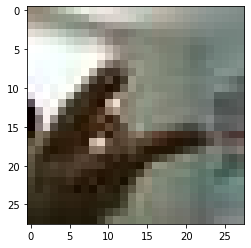

1 번째 이미지의 숫자는 바로  0 입니다.
읽어들인 이미지 개수는 900 입니다.


In [42]:
image_dir_path = os.getenv("HOME") + "/Downloads/merged/"
training_data_num=6300
(x_train, y_train)=load_data(image_dir_path,training_data_num)

#렌덤으로 데이터가 섞였는지 확인해보려고 0번 이미지를 확인했다. 코드를 실행할 때 마다 다른 이미지가 보이는 것을 볼 수 있었다. 
index=0
plt.imshow(x_train[index],cmap=plt.cm.binary)
plt.show()

print( (index+1), '번째 이미지의 숫자는 바로 ',  y_train[index], '입니다.')

# RGB값으로 표현되어있는 값을 정규화
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

# validation set을 만들었는데, 학습 데이터의 20퍼센트를 validation에 사용했다. 
x_val = x_train_norm[-int(training_data_num/20):]
y_val = y_train[-int(training_data_num/20):]

x_train = x_train_norm[:-int(training_data_num/20)]
y_train = y_train[:-int(training_data_num/20)]

# 테스트 데이터 로딩
image_dir_path = os.getenv("HOME") + "/Downloads/김찬호/rock_scissor_paper/"
test_data_num=900
(x_test, y_test) = load_data(image_dir_path,test_data_num) 
x_test_norm = x_test/255.0



In [37]:
#바꿔 볼 수 있는 하이퍼파라미터들
# n_channel은 해당 데이터에서 얼마나 특징을 잡아내는지를 결정하는 척도라고 했다. 
# 그래서 처음에는 대강 분류하고, 그 후에 좀 더 값을 높여 학습시켰다. 
n_channel_1=64
n_channel_2=128
# 해당 값은 neural network의 layer 층 갯수라고 해서 다양한 이미지에 대응하기 위해 값을 높였다. 
n_dense=512
# 학습 횟수
n_train_epoch=100

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
# 오버피팅을 막기 위해 각 학습 단계마다 제대로 학습한 데이터를 드랍시킨다. 그 비율을 0.5로 잡았다. 대신 학습 횟수를 엄청 늘렸다. 
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

training_data_size = x_train.size

# 모델 훈련
# batch_size를 정해준 이유는 한번 학습할 때 전체 데이터를 다 쓰지 않도록 막으려고 정했다. 오버피팅을 막으려고. 
training_result=model.fit(x_train, y_train, batch_size=int(training_data_size/50), epochs=n_train_epoch,validation_data=(x_val,y_val))


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)             

1/1 [==============================] - 0s 35ms/step - loss: 0.7232 - accuracy: 0.6924 - val_loss: 1.0128 - val_accuracy: 0.5429
Epoch 47/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6947 - accuracy: 0.7253 - val_loss: 0.6912 - val_accuracy: 0.7429
Epoch 48/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6919 - accuracy: 0.7088 - val_loss: 0.6651 - val_accuracy: 0.7619
Epoch 49/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6776 - accuracy: 0.7158 - val_loss: 1.0970 - val_accuracy: 0.5079
Epoch 50/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6668 - accuracy: 0.7320 - val_loss: 0.9812 - val_accuracy: 0.5651
Epoch 51/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6579 - accuracy: 0.7312 - val_loss: 0.6790 - val_accuracy: 0.7397
Epoch 52/100
1/1 [==============================] - 0s 34ms/step - loss: 0.6379 - accuracy: 0.7395 - val_loss: 0.7585 - val_accuracy: 0.6921
Epoch 53/100
1/1 [========

해당 모델은 11개의 레이어를 가지게 되었다. 오버피팅을 막아보려고 시도한 여러가지 일 중 하나다.   
1. 레이어 수 늘리기
   레이어 수를 늘리면 좀 더 정교해질 줄 알았다. 그래서 늘려봤다. Dropout을 추가하면 오버피팅을 막을 수 있다고 해서 추가했다. 20퍼센트의 제대로 추론한 케이스들을 드랍시킨다는 의미. 
2. hyper-parameter 조정하기
    - n_channel : 얼마 정도 데이터의 특성을 고려할 것인가? 에 대한 값이라고 들어서 늘려도 보고 줄여도 봤는데 작게는 32, 크게는 512까지 줘봤는데 역시 생각해보니까 데이터가 28*28로 리사이즈되면서 많이 뭉뚱그려지는 영향이 있기에 큰 수는 오히려 오버피팅을 유도하는 것 같았다. 그래서 실험적으로 얻어낸 값이 처음에는 32, 다음 레이어에서는 2배인 64, 그 다음은 2배를 해서 128을 주게 되었다. 
    - n_dense : 정교한 모델을 얻기 위해 뉴럴 네트워크 내의 레이어들을 늘리게 되었다. 하얀 배경에 가위, 바위, 보만 찍히면 가장 좋은 데이터이지만 주변 배경이 나오게 찍힌 경우가 있어서 모델이 정교할 필요가 있었다. 
    - n_epoch : 위의 값들이 매우 큰 값이기 때문에 충분한 학습의 반복이 필요하다고 여겨 100을 줬다.
    - batch_size : 무식하게 실험 수만 늘리면 이것도 학습 데이터에 오버피팅이 되기 때문에 매 학습마다 데이터의 일부만 쓰도록 했다. 
3. 데이터 수 늘리기
    여기서 고생을 했는데, 사실 내 문제는 학습 데이터를 무지막하게 늘릴 생각만 했지, 이 모델이 제대로 작동하도록 판을 깔아주는 일을 하지 않았다는 것이 결정적인 삽질의 시작이었다. 6300개까지 학습시키면 뭐하나, 테스트 데이터가 300개면 모델이 기지개 켜기도 전에 테스트가 종료될 것이다. 아. 허무해라. 그래서 세 배로 데이터를 늘리니까 바로 정확도가 확 올라갔다. 
4. Validation 추가
    데이터가 제대로 학습되었는지 계속 확인하고 싶어서 validation 단계를 넣어서 모니터링했다. 학습 횟수를 100으로 준 이유가 validation이 학습 결과와 수렴하려면 그 정도의 횟수가 필요하더라...
5. 데이터 무작위로 섞기

In [43]:
# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

29/29 - 0s - loss: 0.7099 - accuracy: 0.7389
test_loss: 0.7099137902259827 
test_accuracy: 0.7388888597488403


###회고
오버피팅을 피하기 위해서 오만 짓을 다 해봤는데, 그거 때문에 모델을 200번 정도는 돌린것 같다(중간에 커널 접속이 끊겨서 실행 횟수 초기화).
어떻게든 데이터가 편향되지 않게(이를 위해 데이터를 셔플했다.), 한번에 전부 다 쓰이지 않게 조절하는 것에 집중했다. 설마 실행횟수를 100번까지 늘릴 생각까지 못했는데, batch_size를 정해주게 되면서 실험 횟수를 늘릴 수 밖에 없었다. 그래. 일은 내가 하는게 아니라 컴퓨터가 하지. 그러면서 의외의 하이퍼파라미터를 알게 되었다. 그리고 테스트 데이터도 같이 규모를 키워야 한다는걸 몰라서 학습 데이터 수 늘리기에만 집착했는데 아무리 해도 테스트 데이터에서 좋게 봐줘야 0.54까지만 올라가는 것을 보고 크게 좌절했다. 근데 데이터를 더해주니까 쭉쭉 정확도가 올라가서 너무 당황했다. 데이터 규모는 학습이나 테스트나 둘 다 중요하다. 